# **Soy Price Forecast**

This project aims to forecast the price of a 60-kilogram bag soybeans in Brazil using only the time series of the price itself. The data was collected from CEPEA (Center for Advanced Studies on Applied Economics) and ranges from 13/03/2006 to 10/04/2025

## Packages and Data


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima.arima import auto_arima
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [2]:
data = pd.read_csv('data.csv')

## Preprocessing

First, i will change the names of the features to english, since the data was aquired from a brazilian source, the names are in portuguese

In [30]:
df = data.rename(columns={'data': 'date', 'valor_real': 'price_BRL', 'valor_dolar' : 'price_USD'})

In [31]:
df['date'] = pd.to_datetime(df['date'], dayfirst = True)

i will set the date as the index since we are working with a time series dataset

In [32]:
missing = df.isnull().sum()
duplicated = df.duplicated().sum()
print(f"Total Missing Values: \n{missing}\nTotal Duplicated Values: {duplicated}")

Total Missing Values: 
date         0
price_BRL    0
price_USD    0
dtype: int64
Total Duplicated Values: 0


Since we dont have any missing or duplicated values, we could move on to the EDA.

## EDA

### Data Viz

In [33]:
df.head()

,date,price_BRL,price_USD
0,2006-03-13,27.66,12.96
1,2006-03-14,27.45,12.91
2,2006-03-15,27.58,13.00
3,2006-03-16,26.97,12.78
4,2006-03-17,26.96,12.68


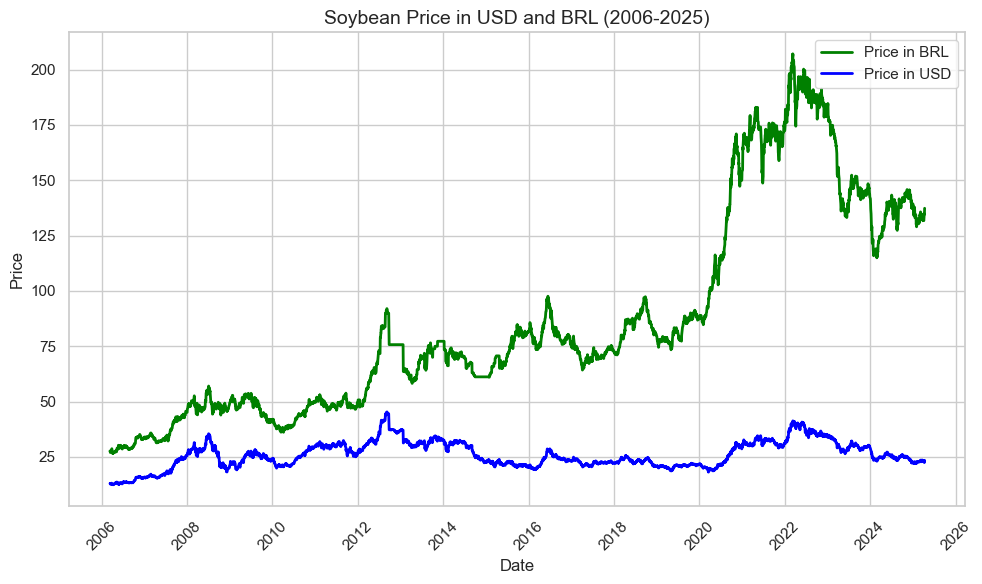

In [34]:
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['price_BRL'], label='Price in BRL', color='green', linewidth=2)
plt.plot(df['date'], df['price_USD'], label='Price in USD', color='blue', linewidth=2)

plt.title('Soybean Price in USD and BRL (2006-2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The price in BRL has a spike in 2020 beacause during the COVID-19 pandemicthe brazilian real has plummeted, with that in mind, is safer for our analysis that we use the price in USD 

In [35]:
df = df.drop(columns=['price_BRL'])

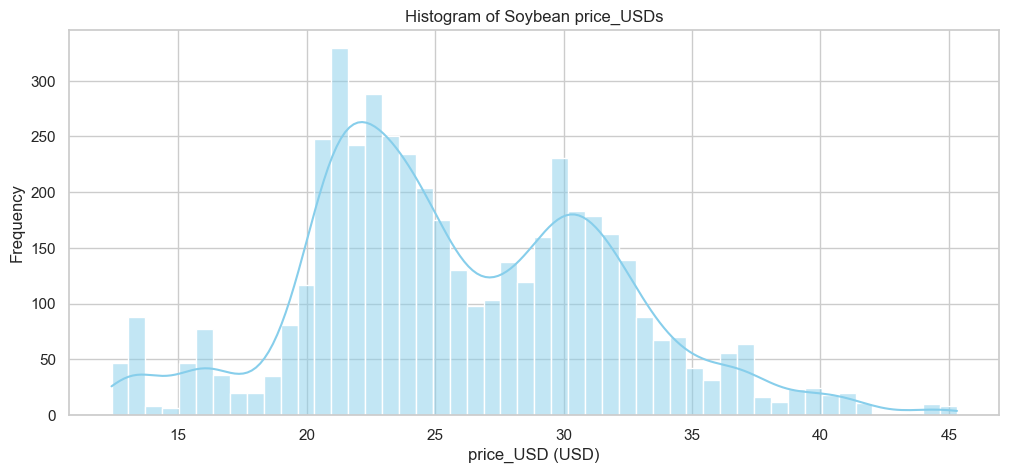

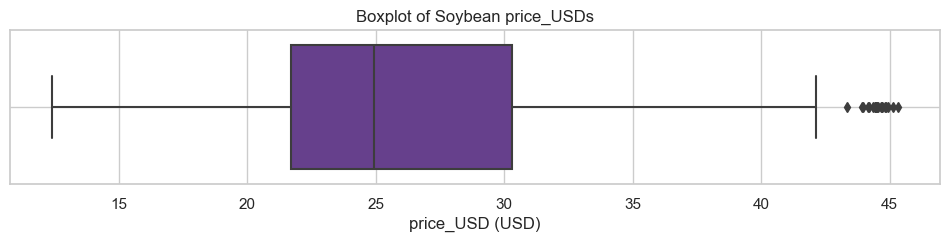

In [36]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 5))
sns.histplot(df['price_USD'], bins=50, kde=True, color='skyblue')
plt.title('Histogram of Soybean price_USDs')
plt.xlabel('price_USD (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 2))
sns.boxplot(x=df['price_USD'], color='rebeccapurple')
plt.title('Boxplot of Soybean price_USDs')
plt.xlabel('price_USD (USD)')
plt.grid(True)
plt.show()

- The distribuition is bimodal and slightly wkewed to the right
- Median price of 25 USD
- There are some outliers on the right, possibly indicatiing supply shocks or speculative bubbles

### Descriptive Statistics

Descriptive Statistics:
count    4757.000000
mean       25.954412
std         5.958429
min        12.400000
25%        21.680000
50%        24.910000
75%        30.320000
max        45.320000
Name: price_USD, dtype: float64


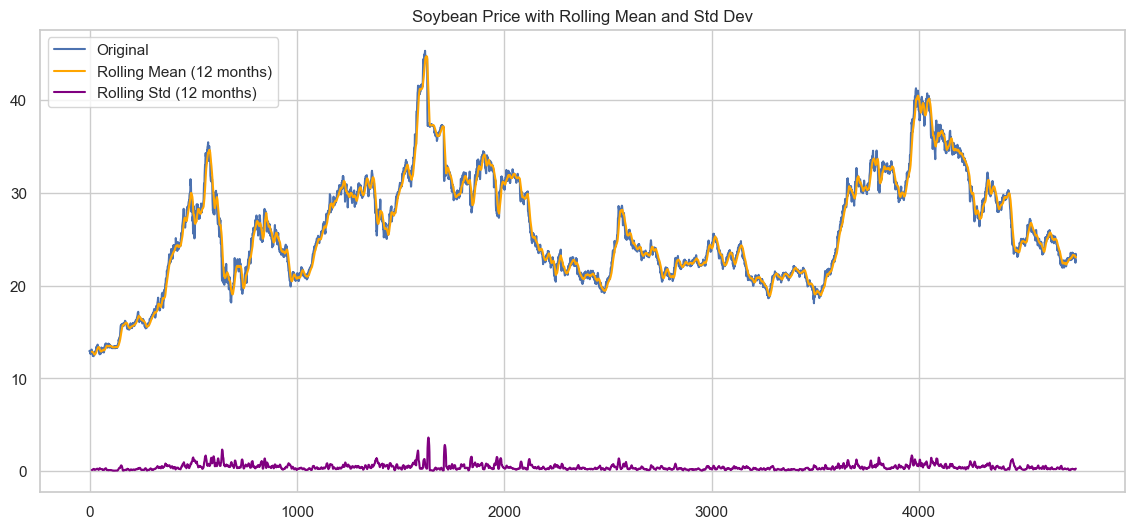

In [37]:
print("Descriptive Statistics:")
print(df['price_USD'].describe())

rolling_mean = df['price_USD'].rolling(window=12).mean()
rolling_std = df['price_USD'].rolling(window=12).std()

plt.figure(figsize=(14, 6))
plt.plot(df['price_USD'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='orange')
plt.plot(rolling_std, label='Rolling Std (12 months)', color='purple')
plt.title('Soybean Price with Rolling Mean and Std Dev')
plt.legend()
plt.grid(True)
plt.show()

- There are long windows of low standart deviation, which is good for a forecast model
- The peaks in standart deviation coincides with spkies and drops, which is usual for commmodity markets
- There are clear cycles, which indicates a possible seasonality. I will make some tests to see if this is true since it impacts on the final model

### Seasonality Analysis

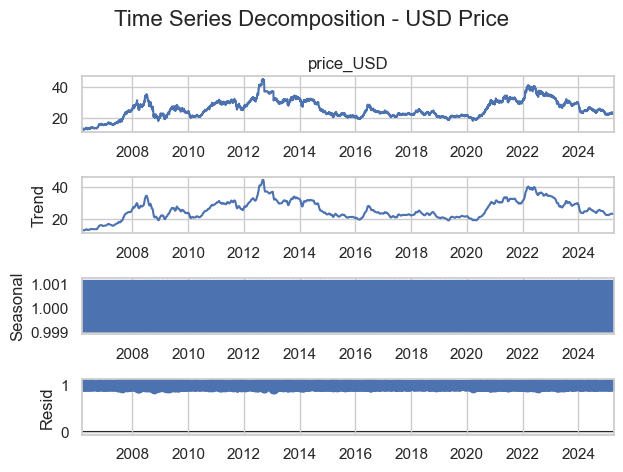

In [38]:
df_ts = df.set_index('date').sort_index()

result = seasonal_decompose(df_ts['price_USD'], model='multiplicative', period=12)

result.plot()
plt.suptitle('Time Series Decomposition - USD Price', fontsize=16)
plt.tight_layout()
plt.show()

I will move on to use a OLS with monthly dummies to verify if any month has a seazonal impact on the price

In [39]:
df['month'] = df['date'].dt.month
dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)

X = dummies
y = df['price_USD']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_USD   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.434
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           8.92e-05
Time:                        17:01:59   Log-Likelihood:                -15221.
No. Observations:                4757   AIC:                         3.047e+04
Df Residuals:                    4745   BIC:                         3.054e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7307      0.294     87.472      0.0

- Prices tend to be significantly higher in July, August, and September compared to January. This make sense, as the harvest takes place between January and April, scarcity begins at that time. The price variation ranges from 0.91-0.95 USD
- F-statistic 3.434 and p-value < 0.05 indicates that the model is statisticaly significant
- Omnibus with a low p-value indicates that the values dont have a normal distribution

At this point is important to find out if the series is stationary or non-stationary since this have a huge influence in which model will be used in the forecast

### Stationarity Tests

In [40]:
serie = df['price_USD'].dropna()

def print_adf_test(series):
    stat, pvalue, _, _, crit_values, _ = adfuller(series)
    print("=== ADF Test ===")
    print(f"Estatística: {stat:.4f}")
    print(f"p-valor: {pvalue:.4f}")
    print("Críticos:")
    for key, value in crit_values.items():
        print(f"  {key}: {value:.4f}")

def print_kpss_test(series):
    stat, pvalue, _, crit_values = kpss(series, regression='c', nlags='auto')
    print("=== KPSS Test ===")
    print(f"Estatística: {stat:.4f}")
    print(f"p-valor: {pvalue:.4f}")
    print("Críticos:")
    for key, value in crit_values.items():
        print(f"  {key}: {value:.4f}")

def print_pp_test(series):
    result = PhillipsPerron(series)
    print("=== Phillips-Perron Test ===")
    print(f"Estatística: {result.stat:.4f}")
    print(f"p-valor: {result.pvalue:.4f}")
    print("Críticos:")
    for key, value in result.critical_values.items():
        print(f"  {key}: {value:.4f}")

print_adf_test(serie)
print_kpss_test(serie)
print_pp_test(serie)

=== ADF Test ===
Estatística: -2.9411
p-valor: 0.0408
Críticos:
  1%: -3.4317
  5%: -2.8622
  10%: -2.5671
=== KPSS Test ===
Estatística: 1.2201
p-valor: 0.0100
Críticos:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=== Phillips-Perron Test ===
Estatística: -2.8477
p-valor: 0.0518
Críticos:
  1%: -3.4317
  5%: -2.8621
  10%: -2.5671


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The KPSS and PP tests indicates that the series is **non-stationary**.I will run a PACF and ACF to understend the autocorelation and partial autocorelation of the time series

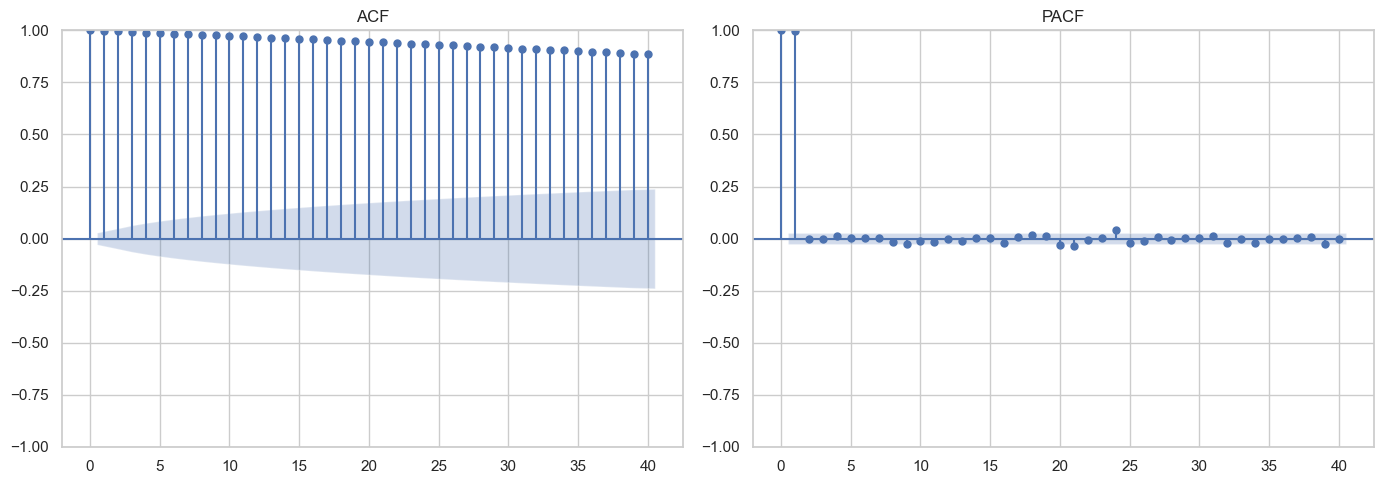

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df['price_USD'], ax=axes[0], lags=40)
axes[0].set_title('ACF')

plot_pacf(df['price_USD'], ax=axes[1], lags=40, method='ywm')  # ou método 'ld', 'ols'
axes[1].set_title('PACF')

plt.tight_layout()
plt.show()

- The ACF corroborates with the non-sationary
- The PACF indicates that the series is AR(1), so, i will need to diferentiate the data at least once

In [43]:
df_diff = df['price_USD'].diff().dropna()

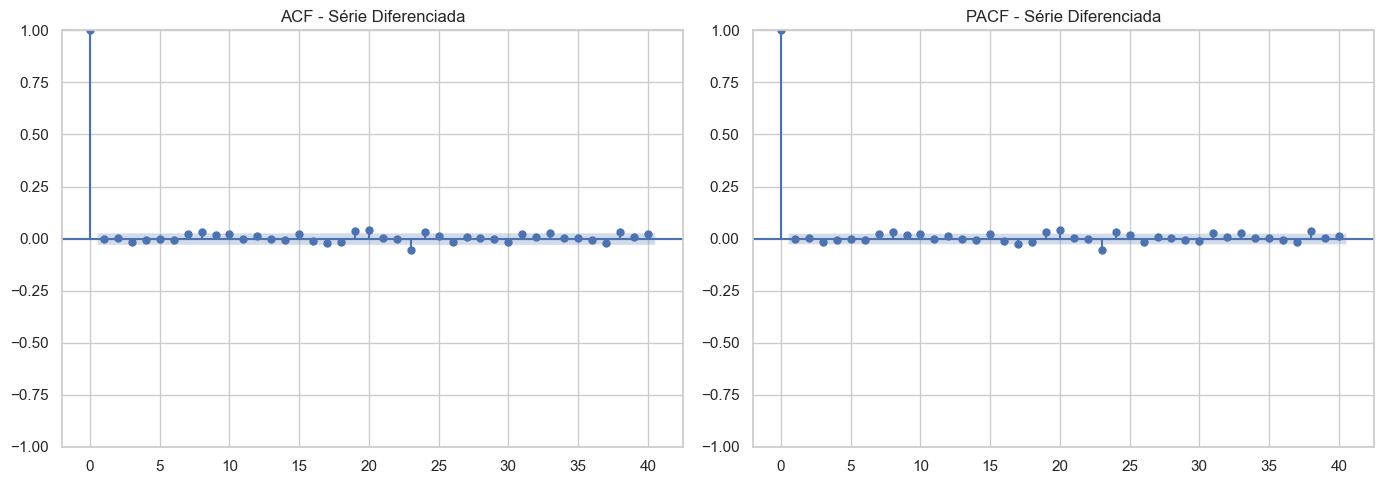

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_diff, ax=axes[0], lags=40)
axes[0].set_title('ACF - Série Diferenciada')

plot_pacf(df_diff, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('PACF - Série Diferenciada')

plt.tight_layout()
plt.show()

After the diferentiation process, the time series is now stationary

Now that we have those informations about the data:
- Univariate
- Bimodal
- Few Outliers
- Positive and multiplicative seasonality in july, august and september
- Non-Stationary

It's safe to asume that SARIMA (Seasonal ARIMA) will be a good model for the forecast, but i will also create some features so i can run a XGBoost to try something more robust

## Feature Engineering

First of all,  to avoid data leakage, iwill make the train test split using the 80-20 ratio

In [46]:
train_size = int(len(df_diff) * 0.8)

train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

print("Train Period:", train['date'].min(), "to", train['date'].max())
print("Test Period:", test['date'].min(), "to", test['date'].max())

Train Period: 2006-03-13 00:00:00 to 2021-06-17 00:00:00
Test Period: 2021-06-18 00:00:00 to 2025-04-10 00:00:00


The XGBoost model needs more information about the dataset to perform well, so I will create the following features:

- **Lags**: Past values of the price to capture temporal dependencies
- **Rolling average**: Smoothed trends over different time windows
- **Momentum**: Recent percentage changes to reflect dynamics in short-term
- **Seasonality components**: Clendar-based features like month, weekday, and known seasonal periods
- **Seasonality Dummie**: Indicates if it is a peak month

In [47]:
train['lag_1'] = train['price_USD'].shift(1)
train['lag_2'] = train['price_USD'].shift(2)
train['lag_3'] = train['price_USD'].shift(3)
train['lag_7'] = train['price_USD'].shift(7)    # 1 week
train['lag_30'] = train['price_USD'].shift(30)  # 1 month
train['lag_365'] = train['price_USD'].shift(365)  # 1 year

train['ma_3'] = train['price_USD'].rolling(3).mean()
train['ma_7'] = train['price_USD'].rolling(7).mean()
train['ma_14'] = train['price_USD'].rolling(14).mean()
train['ma_30'] = train['price_USD'].rolling(30).mean()

train['ret_1'] = train['price_USD'].pct_change(1)
train['ret_3'] = train['price_USD'].pct_change(3)
train['ret_7'] = train['price_USD'].pct_change(7)

train['day'] = train['date'].dt.day
train['weekday'] = train['date'].dt.weekday  # 0 = segunda, 6 = domingo
train['month'] = train['date'].dt.month

train['peak'] = train['month'].apply(lambda x: 1 if x in [7, 8, 9] else 0)

train['year'] = train['date'].dt.year

train = train.dropna().reset_index(drop=True)

In [48]:
train.head()

,date,price_USD,month,lag_1,lag_2,lag_3,lag_7,lag_30,lag_365,ma_3,ma_7,ma_14,ma_30,ret_1,ret_3,ret_7,day,weekday,peak,year
0,2007-08-30,20.13,8,19.83,19.22,19.44,18.40,17.51,12.96,19.726667,19.415714,18.926429,18.523333,0.015129,0.035494,0.094022,30,3,1,2007
1,2007-08-31,20.25,8,20.13,19.83,19.22,18.64,17.76,12.91,20.070000,19.645714,18.997857,18.606333,0.005961,0.053590,0.086373,31,4,1,2007
2,2007-09-03,20.28,9,20.25,20.13,19.83,19.08,17.45,13.00,20.220000,19.817143,19.096429,18.700667,0.001481,0.022693,0.062893,3,0,1,2007
3,2007-09-04,20.76,9,20.28,20.25,20.13,19.57,17.33,12.78,20.430000,19.987143,19.262857,18.815000,0.023669,0.031297,0.060807,4,1,1,2007
4,2007-09-05,20.77,9,20.76,20.28,20.25,19.44,17.43,12.68,20.603333,20.177143,19.488571,18.926333,0.000482,0.025679,0.068416,5,2,1,2007


In [49]:
test.head()

,date,price_USD,month
3804,2021-06-18,30.26,6
3805,2021-06-21,30.82,6
3806,2021-06-22,31.23,6
3807,2021-06-23,30.75,6
3808,2021-06-24,30.43,6


In [56]:
features = ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_30', 'lag_365', 
            'ma_3', 'ma_7', 'ma_14', 'ma_30', 'ret_1', 'ret_3', 'ret_7', 
            'day', 'weekday', 'peak', 'year']  

X_train = train[features]
y_train = train['price_USD']


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


test['lag_1'] = test['price_USD'].shift(1)
test['lag_2'] = test['price_USD'].shift(2)
test['lag_3'] = test['price_USD'].shift(3)
test['lag_7'] = test['price_USD'].shift(7)
test['lag_30'] = test['price_USD'].shift(30)
test['lag_365'] = test['price_USD'].shift(365)

test['ma_3'] = test['price_USD'].rolling(window=3).mean()
test['ma_7'] = test['price_USD'].rolling(window=7).mean()
test['ma_14'] = test['price_USD'].rolling(window=14).mean()
test['ma_30'] = test['price_USD'].rolling(window=30).mean()

test['ret_1'] = test['price_USD'].pct_change(periods=1)
test['ret_3'] = test['price_USD'].pct_change(periods=3)
test['ret_7'] = test['price_USD'].pct_change(periods=7)

test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday
test['peak'] = test['month'].apply(lambda x: 1 if x in [11, 12, 1, 2] else 0)
test['year'] = test['date'].dt.year

test[features] = test[features].fillna(test[features].mean())

X_test_filled = test[features]

rf_pred = rf_model.predict(X_test_filled)

y_test_filled = test['price_USD']  
mse = mean_squared_error(y_test_filled, rf_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test_filled, rf_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MSE: 0.11
RMSE: 0.33
R²: 0.9959


**Overfit, i will fix it later**